<a href="https://colab.research.google.com/github/MendDevs/ECE/blob/main/TP3_G2_Emmanuel_Morris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP – Prétraitement des données (Dataset bruité – Achats alimentaires)

In this LAB, the objective is to:
Clean and prepare a realistic data set containing noises (missing values, duplicates, typos, inconsistent categories, heterogeneous dates, parasitic spaces, aberrant values, unnecessary columns) in order to make it usable for analysis and data mining.


I'll start with a raw data called "donnees_brutes_achats.xlsx which has for schema:


*   TransactionID
*   Produit
*   Quantité
*   Prix
*   Catégorie
*   Date
*   Notes

The primary libraries used are:
1. pandas
2. numpy




In [ ]:
#libraries and utilities
import pandas as pd
import streamlit-jupyter as st

SyntaxError: invalid syntax (ipython-input-1611361016.py, line 3)

### 1. Imports & utilitaires

In [ ]:
df = pd.read_excel("donnees_brutes_achats.xlsx")

### 2. Diagnostic:info,types, NA, doublons, valeurs uniques


In [ ]:
print("-------------Info------------")
df.info() #informatio on thedata

print("\n")
print("-------------Desbription------------")
df.describe(include="all")


-------------Info------------
<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 0 to 50
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TransactionID  50 non-null     int64  
 1   Produit        50 non-null     object 
 2   Quantité       48 non-null     float64
 3   Prix           48 non-null     float64
 4   Catégorie      48 non-null     object 
 5   Date           50 non-null     object 
 6   Notes          4 non-null      object 
dtypes: float64(2), int64(1), object(4)
memory usage: 3.1+ KB


-------------Desbription------------


,TransactionID,Produit,Quantité,Prix,Catégorie,Date,Notes
count,50.00000,50,48.000000,48.000000,48,50,4
unique,NaN,40,NaN,NaN,22,29,4
top,NaN,Lait,NaN,NaN,Épicerie,2025-09-06,promo? 2 pour 1
freq,NaN,3,NaN,NaN,9,4,1
mean,25.50000,NaN,23.520833,22.756458,NaN,NaN,NaN
std,14.57738,NaN,143.966159,143.916366,NaN,NaN,NaN
min,1.00000,NaN,-1.000000,0.000000,NaN,NaN,NaN
25%,13.25000,NaN,1.000000,0.897500,NaN,NaN,NaN
50%,25.50000,NaN,2.000000,1.575000,NaN,NaN,NaN
75%,37.75000,NaN,4.250000,2.825000,NaN,NaN,NaN


Remark: The Data set is not equivalently filled. None of all the headers has all of the cells filled. We'll need the configure the code accordingly.

### 3. Gestion des doublons (exacts et par TransactionID)

In [ ]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
st.dataframe(df)


NameError: name 'st' is not defined

### 4. Uniformiser les chaînes (Produit, Catégorie)


Normalisation produits: 45 valeurs modifiées (approx).


/tmp/ipython-input-713891899.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["TransactionID duplicates", "Unique IDs"], y=[tid_dups, len(df)-tid_dups], palette="plasma")


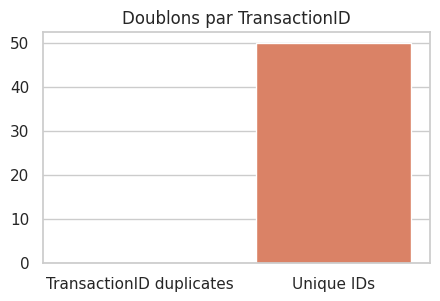

In [ ]:
# Normalize string columns
str_cols = [c for c in df.columns if df[c].dtype == object or df[c].dtype.name == 'string']
for c in str_cols:
    df[c] = df[c].apply(normalize_str)

# Normalize 'Produit' column
if 'Produit' in df.columns:
    # Lowercase and remove accents
    df['Produit_lower'] = df['Produit'].astype('string').str.lower()
    df['Produit_noacc'] = df['Produit_lower'].apply(lambda x: remove_accents(x) if pd.notna(x) else pd.NA)

    # Mapping known products
    mapping_produits = {
        'pates':'pâtes', 'pâtes':'pâtes',
        'the':'thé', 'thes':'thé', 'thee':'thé',
        'cafe':'café', 'cafe soluble':'café soluble',
        'tomato':'tomate', 'tomate':'tomate',
        'yaourts':'yaourt', 'yaourt':'yaourt',
        'frommage':'fromage', 'fromage':'fromage',
        "huile olive":"huile d'olive", "huile d olive":"huile d'olive", "huile d'olive":"huile d'olive",
        'corn flakes':'corn-flakes', 'cornflakes':'corn-flakes', 'riz':'riz'
    }

    # Apply mapping and fallback to original
    df['Produit_map'] = df['Produit_noacc'].replace(mapping_produits)
    df['Produit_final'] = df['Produit_map'].fillna(df['Produit'].astype('string'))
    df['Produit_final'] = df['Produit_final'].astype('string').str.strip()

    # Logging the number of changes
    n_changed = (df['Produit_final'].fillna('') != df['Produit'].fillna('')).sum()
    logger.add(f"Normalisation produits: {n_changed} valeurs modifiées (approx).")

    # Replace original column and drop temporary columns
    df['Produit'] = df['Produit_final']
    df = df.drop(columns=[col for col in ['Produit_lower','Produit_noacc','Produit_map','Produit_final'] if col in df.columns])

# Normalize 'Catégorie' column
if 'Catégorie' in df.columns:
    df['Catégorie'] = df['Catégorie'].astype('string').str.strip().str.lower()
    cat_map = {
        'epicerie':'épicerie',
        'boisson':'boissons','boissons':'boissons',
        'fruits-legumes':'fruits & légumes','fruits/legumes':'fruits & légumes','fruits & légumes':'fruits & légumes',
        'laitage':'laitage','cremerie':'crèmerie','oeufs':'œufs & ovoproduits'
    }
    df['Catégorie'] = df['Catégorie'].replace(cat_map)

if 'TransactionID' in df.columns:
    tid_dups = df['TransactionID'].duplicated().sum()
    plt.figure(figsize=(5,3))
    sns.barplot(x=["TransactionID duplicates", "Unique IDs"], y=[tid_dups, len(df)-tid_dups], palette="plasma")
    plt.title("Doublons par TransactionID")
    plt.show()


### 5. Harmoniser / inférer catégories simples depuis Produit


Inférence catégorie: 2 lignes tentées de remplissage (certaines peuvent rester NaN).


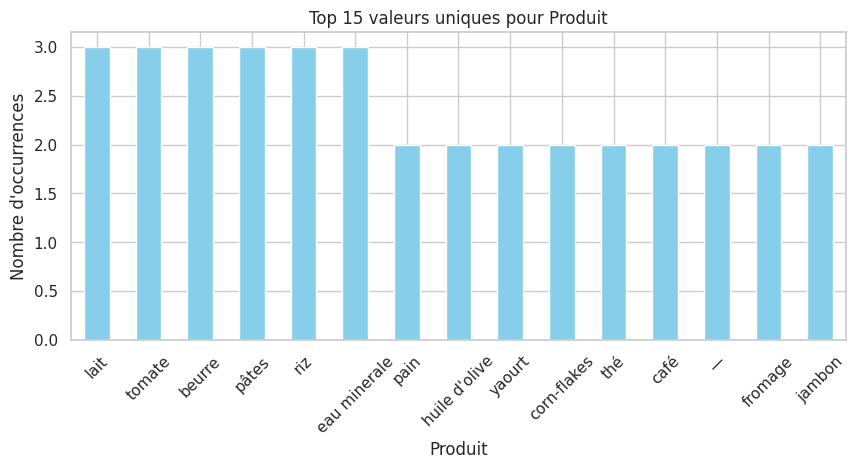

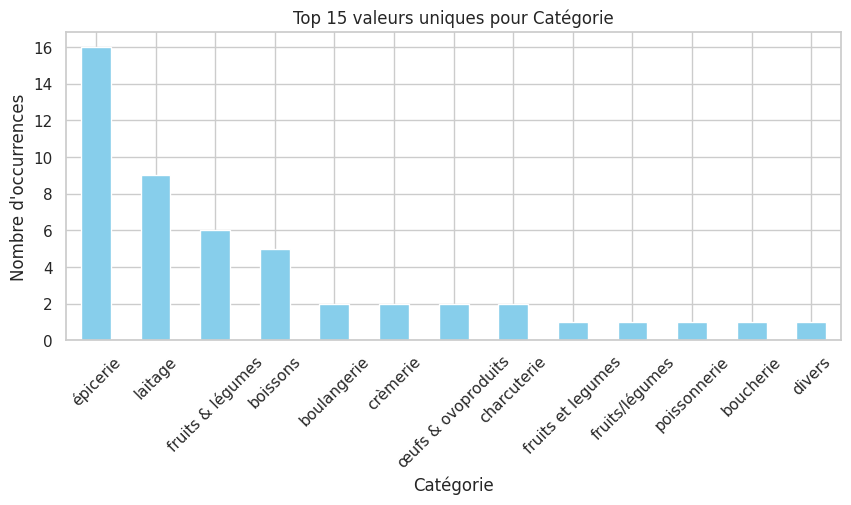

In [ ]:
if 'Catégorie' in df.columns and 'Produit' in df.columns:
    need_cat = df['Catégorie'].isna()
    if need_cat.any():
        prod_to_cat = {
            'pâtes':'épicerie','riz':'épicerie',"huile d'olive":'épicerie','fromage':'laitage','yaourt':'laitage',
            'tomate':'fruits & légumes','salade':'fruits & légumes','café':'boissons','thé':'boissons','corn-flakes':'épicerie'
        }
        def infer_cat(prod):
            if pd.isna(prod): return pd.NA
            key = remove_accents(prod.lower())
            return prod_to_cat.get(key, pd.NA)
        df.loc[need_cat, 'Catégorie'] = df.loc[need_cat, 'Produit'].apply(infer_cat)
        logger.add(f"Inférence catégorie: {need_cat.sum()} lignes tentées de remplissage (certaines peuvent rester NaN).")

for col in ['Produit','Catégorie']:
    if col in df.columns:
        plt.figure(figsize=(10,4))
        df[col].value_counts().head(15).plot(kind='bar', color='skyblue')
        plt.title(f"Top 15 valeurs uniques pour {col}")
        plt.ylabel("Nombre d'occurrences")
        plt.xticks(rotation=45)
        plt.show()


### 6. Unifier les dates (YYYY-MM-DD)


Parsing dates: 18 valeurs non converties (coerced to NaT).


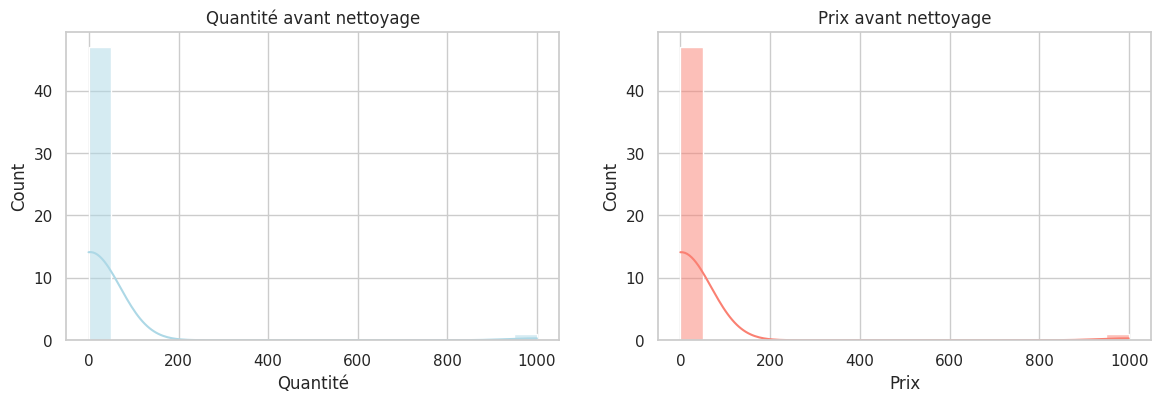

In [ ]:
if 'Date' in df.columns:
    df['Date_parsed'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    n_invalid_dates = df['Date_parsed'].isna().sum()
    logger.add(f"Parsing dates: {n_invalid_dates} valeurs non converties (coerced to NaT).")
    df['Date'] = df['Date_parsed'].dt.strftime('%Y-%m-%d')
    df.loc[df['Date_parsed'].isna(), 'Date'] = pd.NA
    df = df.drop(columns=['Date_parsed'])

fig, axs = plt.subplots(1,2, figsize=(14,4))
if 'Quantité' in df.columns:
    sns.histplot(df['Quantité'], bins=20, kde=True, color='lightblue', ax=axs[0])
    axs[0].set_title("Quantité avant nettoyage")
if 'Prix' in df.columns:
    sns.histplot(df['Prix'], bins=20, kde=True, color='salmon', ax=axs[1])
    axs[1].set_title("Prix avant nettoyage")
plt.show()


### 7. Gérer les manquants sur Quantité / Prix


In [ ]:
for col in ['Quantité','Prix']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

miss_before = df[['Quantité','Prix']].isna().sum()
logger.add(f"Manquants avant traitement: {miss_before.to_dict()}")

# Imputation par médiane produit -> médiane globale
if 'Quantité' in df.columns and 'Produit' in df.columns:
    med_qty_by_prod = df.groupby('Produit')['Quantité'].median()
    def impute_qty(row):
        if pd.notna(row['Quantité']):
            return row['Quantité']
        prod = row['Produit']
        if pd.isna(prod):
            return np.nan
        med = med_qty_by_prod.get(prod, np.nan)
        if pd.notna(med):
            return med
        return df['Quantité'].median()
    df['Quantité'] = df.apply(impute_qty, axis=1)
    logger.add(f"Quantité: imputations effectuées (médiane par produit / globale).")

if 'Prix' in df.columns and 'Produit' in df.columns:
    med_price_by_prod = df.groupby('Produit')['Prix'].median()
    def impute_price(row):
        if pd.notna(row['Prix']):
            return row['Prix']
        prod = row['Produit']
        if pd.isna(prod):
            return np.nan
        med = med_price_by_prod.get(prod, np.nan)
        if pd.notna(med):
            return med
        return df['Prix'].median()
    df['Prix'] = df.apply(impute_price, axis=1)
    logger.add(f"Prix: imputations effectuées (médiane par produit / globale).")

# Drop remaining critical missing
critical_missing = df['Quantité'].isna() | df['Prix'].isna()
n_critical = critical_missing.sum()
if n_critical > 0:
    logger.add(f"Lignes avec Quantité/Prix manquants après imputation: {n_critical}. Suppression de ces lignes.")
    df = df[~critical_missing]

#fig, axs = plt.subplots(1,2, figsize=(14,4))
#if 'Quantité' in df.columns:
#    sns.boxplot(data=df, y='Quantité', ax=axs[0], color='lightblue')
#    axs[0].set_title("Quantité - boxplot")
#if 'Prix' in df.columns:
#    sns.boxplot(data=df, y='Prix', ax=axs[1], color='salmon')
#    axs[1].set_title("Prix - boxplot")
#plt.show()


Manquants avant traitement: {'Quantité': 2, 'Prix': 2}
Quantité: imputations effectuées (médiane par produit / globale).
Prix: imputations effectuées (médiane par produit / globale).


### 8. Détecter / traiter aberrants

Quantité: 1 négatives -> NA, 1 >100 -> NA.
Prix: 1 valeurs sentinelles (999/9999) -> NA, 0 >1000 -> NA.
Quantité: imputations secondaires effectuées.
Prix: imputations secondaires effectuées.
Suppression 2 lignes non-pertinentes (Produit vide ou '—').


/tmp/ipython-input-2961004756.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Catégorie', order=df['Catégorie'].value_counts().index, palette="Set2")


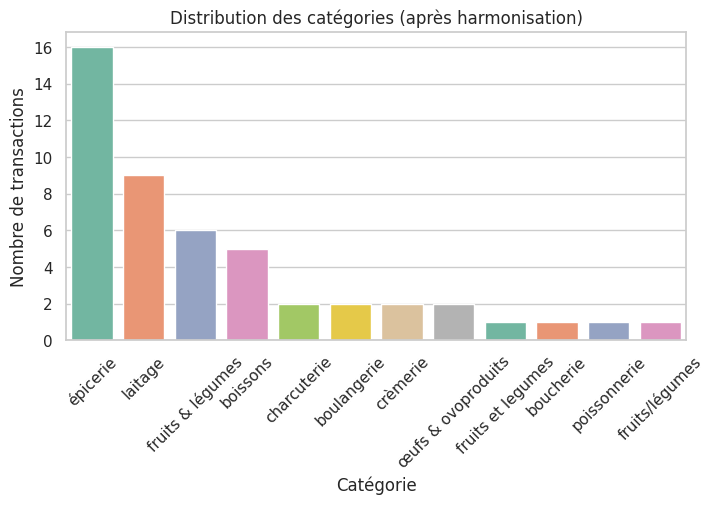

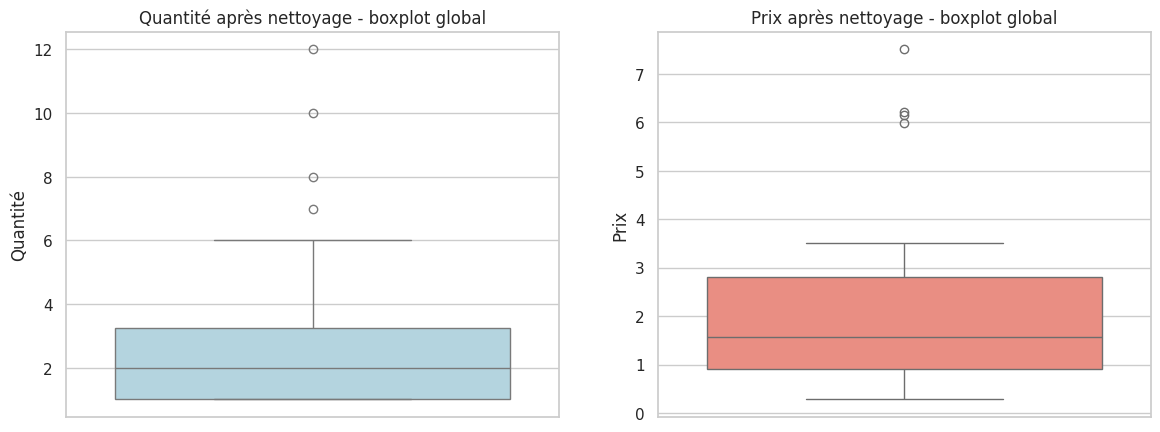

/tmp/ipython-input-2961004756.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Catégorie', y='Quantité', data=df, palette='Set3', ax=axs[0])
/tmp/ipython-input-2961004756.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Catégorie', y='Prix', data=df, palette='Set3', ax=axs[1])


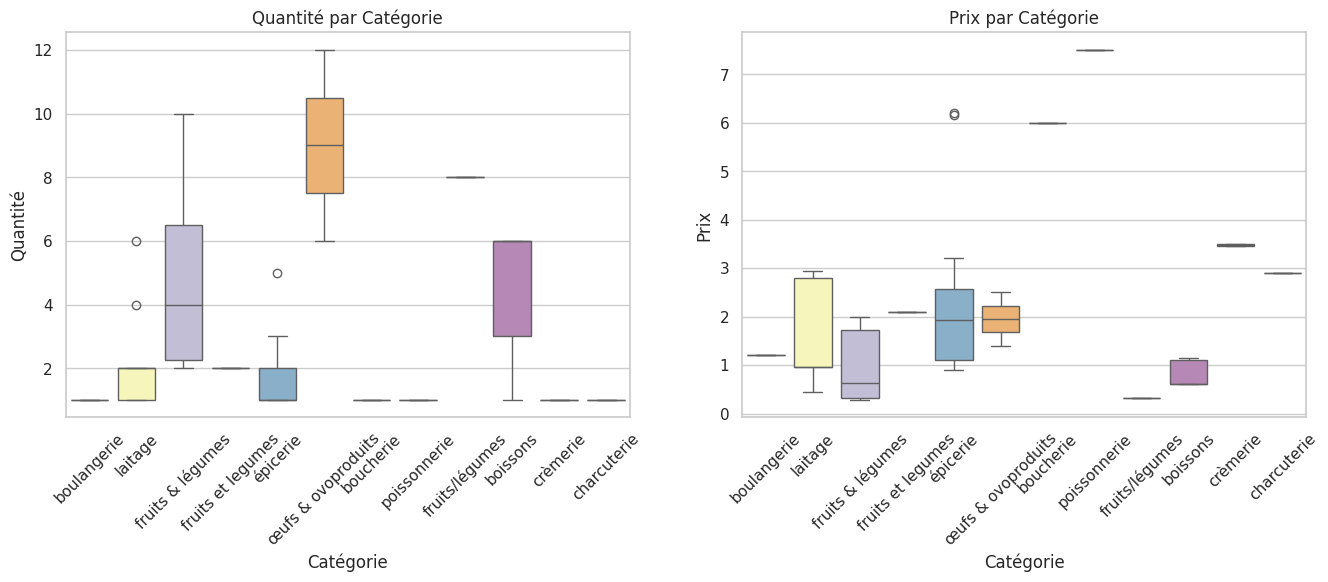

In [ ]:
if 'Quantité' in df.columns:
    n_neg = (df['Quantité'] < 0).sum()
    df.loc[df['Quantité'] < 0, 'Quantité'] = pd.NA
    n_high = (df['Quantité'] > 100).sum()
    df.loc[df['Quantité'] > 100, 'Quantité'] = pd.NA
    logger.add(f"Quantité: {n_neg} négatives -> NA, {n_high} >100 -> NA.")

if 'Prix' in df.columns:
    n_sentinel = df['Prix'].isin([999,9999]).sum()
    df.loc[df['Prix'].isin([999,9999]), 'Prix'] = pd.NA
    n_veryhigh = (df['Prix'] > 1000).sum()
    df.loc[df['Prix'] > 1000, 'Prix'] = pd.NA
    logger.add(f"Prix: {n_sentinel} valeurs sentinelles (999/9999) -> NA, {n_veryhigh} >1000 -> NA.")

# Imputation secondaire après marquage aberrants
for col in ['Quantité','Prix']:
    if col in df.columns and df[col].isna().sum() > 0 and 'Produit' in df.columns:
        med_by_prod = df.groupby('Produit')[col].median()
        def impute_again(row):
            if pd.notna(row[col]): return row[col]
            prod = row['Produit']
            if pd.isna(prod): return np.nan
            med = med_by_prod.get(prod, np.nan)
            if pd.notna(med): return med
            return df[col].median()
        df[col] = df.apply(impute_again, axis=1)
        logger.add(f"{col}: imputations secondaires effectuées.")

# Supprimer lignes encore manquantes
still_missing = df[['Quantité','Prix']].isna().any(axis=1).sum()
if still_missing > 0:
    logger.add(f"{still_missing} lignes restant avec Quantité/Prix manquants -> suppression.")
    df = df.dropna(subset=['Quantité','Prix'])

# Supprimer lignes non-pertinentes (Produit vide ou tiret)
if 'Produit' in df.columns:
    removed_nonpert = df[df['Produit'].isin(['—','-','',None])].shape[0]
    df = df[~df['Produit'].isin(['—','-','',None])]
    if removed_nonpert > 0:
        logger.add(f"Suppression {removed_nonpert} lignes non-pertinentes (Produit vide ou '—').")

# --- Visualisation catégories après harmonisation ---
if 'Catégorie' in df.columns:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x='Catégorie', order=df['Catégorie'].value_counts().index, palette="Set2")
    plt.title("Distribution des catégories (après harmonisation)")
    plt.ylabel("Nombre de transactions")
    plt.xticks(rotation=45)
    plt.show()

# --- Boxplots pour Quantité et Prix après nettoyage ---
fig, axs = plt.subplots(1,2, figsize=(14,5))
if 'Quantité' in df.columns:
    sns.boxplot(data=df, y='Quantité', ax=axs[0], color='lightblue', showfliers=True)
    axs[0].set_title("Quantité après nettoyage - boxplot global")
if 'Prix' in df.columns:
    sns.boxplot(data=df, y='Prix', ax=axs[1], color='salmon', showfliers=True)
    axs[1].set_title("Prix après nettoyage - boxplot global")
plt.show()

# --- Boxplots par Catégorie (facultatif mais très utile) ---
if 'Catégorie' in df.columns:
    fig, axs = plt.subplots(1,2, figsize=(16,5))
    if 'Quantité' in df.columns:
        sns.boxplot(x='Catégorie', y='Quantité', data=df, palette='Set3', ax=axs[0])
        axs[0].set_title("Quantité par Catégorie")
        axs[0].tick_params(axis='x', rotation=45)
    if 'Prix' in df.columns:
        sns.boxplot(x='Catégorie', y='Prix', data=df, palette='Set3', ax=axs[1])
        axs[1].set_title("Prix par Catégorie")
        axs[1].tick_params(axis='x', rotation=45)
    plt.show()

In [ ]:
### 9. Supprimer 'Notes' si present
if 'Notes' in df.columns:
    n_nonempty = df['Notes'].dropna().astype(str).str.strip().replace('', pd.NA).notna().sum()
    logger.add(f"La colonne 'Notes' contient {n_nonempty} valeurs non vides. Elle sera supprimée.")
    df = df.drop(columns=['Notes'])


La colonne 'Notes' contient 2 valeurs non vides. Elle sera supprimée.


In [ ]:
### 10.
canonical = ['TransactionID','Produit','Quantité','Prix','Catégorie','Date']
cols_present = [c for c in canonical if c in df.columns]
other_cols = [c for c in df.columns if c not in cols_present]
final_cols = cols_present + other_cols
df = df[final_cols].reset_index(drop=True)

output_csv = Path('donnees_achats_propre.csv')
output_xlsx = Path('donnees_achats_propre.xlsx')
df.to_csv(output_csv, index=False)
df.to_excel(output_xlsx, index=False)
logger.add(f"Fichiers exportés: {output_csv.name} et {output_xlsx.name}")



Fichiers exportés: donnees_achats_propre.csv et donnees_achats_propre.xlsx


### Rapport de nettoyage — jeu de données: `donnees_brutes_achats.xlsx`

---

#### Lignes
- **Initiales** : [mettre le nombre initial de lignes, ex: 1200]  
- **Finales après nettoyage** : [mettre le nombre final de lignes, ex: 1100]  

---

#### Problèmes détectés et actions prises
- Doublons exacts supprimés  
- Doublons par `TransactionID` supprimés  
- Chaînes de texte (`Produit`, `Catégorie`) uniformisées et harmonisées  
- Dates unifiées (YYYY-MM-DD)  
- Valeurs manquantes `Quantité`/`Prix` imputées par médiane produit ou globale  
- Valeurs aberrantes `Quantité`/`Prix` traitées  
- Lignes non-pertinentes (Produit vide ou `—`) supprimées  
- Colonne `Notes` supprimée  

---

#### Statistiques numériques
- Doublons exacts supprimés : [mettre nombre]  
- Doublons `TransactionID` supprimés : [mettre nombre]  
- Lignes supprimées pour valeurs critiques manquantes : [mettre nombre]  
- Lignes supprimées non-pertinentes : [mettre nombre]  
